# Team 11: Movie Recommendation Project
##### Team Members: Riya Sawant, Sakshi Gondkar, Roberto Tapia, Amanjit Singh

### Import Libraries

In [1]:
# import libraries 
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import ast
import colorama
from colorama import Fore
from PIL import Image
from pprint import pprint

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('omw-1.4')

### Load and Examine Data

In [2]:
#Display Dataframe
movies_df = pd.read_csv('tmdb_5000_movies.csv')
movies_df.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466


In [3]:
#Display Dataframe
credits_df = pd.read_csv('tmdb_5000_credits.csv')
credits_df.head(3)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


### Combine Dataframes

In [4]:
#Combine the 2 Dataframes and Display
combined_df = movies_df.merge(credits_df, how="left", left_on="id", right_on="movie_id")
combined_df = combined_df.drop("movie_id", axis=1)
combined_df.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


### Feature Selection 

In [5]:
# feature selection
features = ['id', 'original_title', 'overview', 'genres', 'keywords', 'tagline', 'cast', 'crew', 'vote_count', 'vote_average']
combined_df = combined_df[features]

### Examine data from new (combined) dataframe

In [6]:
#Show the demensions of the new dataframe
combined_df.shape

(4803, 10)

In [7]:
#Check for duplicates
combined_df.duplicated().sum()

0

In [8]:
#Check for duplicates in the ID collumn
combined_df.duplicated("id").sum()

0

In [9]:
#Check for nulls
combined_df.isnull().sum()

id                  0
original_title      0
overview           31
genres              0
keywords            0
tagline           844
cast                0
crew                0
vote_count          0
vote_average        0
dtype: int64

In [10]:
#Look at the datatype in dataframe
combined_df.dtypes

id                  int64
original_title     object
overview           object
genres             object
keywords           object
tagline            object
cast               object
crew               object
vote_count          int64
vote_average      float64
dtype: object

In [11]:
#Fill the null values with blank space
combined_df['tagline'] = combined_df['tagline'].fillna('')
combined_df['overview'] = combined_df['overview'].fillna('')

combined_df.isnull().sum()

id                0
original_title    0
overview          0
genres            0
keywords          0
tagline           0
cast              0
crew              0
vote_count        0
vote_average      0
dtype: int64

In [12]:
#Display dataframe
combined_df.head(5)

,id,original_title,overview,genres,keywords,tagline,cast,crew,vote_count,vote_average
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",Enter the World of Pandora.,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",11800,7.2
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","At the end of the world, the adventure begins.","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",4500,6.9
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",A Plan No One Escapes,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",4466,6.3
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",The Legend Ends,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",9106,7.6
4,49529,John Carter,"John Carter is a war-weary, former military ca...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...","Lost in our world, found in another.","[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",2124,6.1


In [13]:
#Show the top 3 rows of overview column with blank space 
combined_df[combined_df["overview"] == ""].head(3)

,id,original_title,overview,genres,keywords,tagline,cast,crew,vote_count,vote_average
65,155,The Dark Knight,,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 28, ""name...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",Why So Serious?,"[{""cast_id"": 35, ""character"": ""Bruce Wayne"", ""...","[{""credit_id"": ""55a0eb4a925141296b0010f8"", ""de...",12002,8.2
77,150540,Inside Out,,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 35, ""name...","[{""id"": 1566, ""name"": ""dream""}, {""id"": 6513, ""...",Meet the little voices inside your head.,"[{""cast_id"": 4, ""character"": ""Joy (voice)"", ""c...","[{""credit_id"": ""56098866c3a368681000003a"", ""de...",6560,8.0
94,118340,Guardians of the Galaxy,,"[{""id"": 28, ""name"": ""Action""}, {""id"": 878, ""na...","[{""id"": 8828, ""name"": ""marvel comic""}, {""id"": ...",All heroes start somewhere.,"[{""cast_id"": 1, ""character"": ""Peter Quill / St...","[{""credit_id"": ""538ce329c3a3687155003358"", ""de...",9742,7.9


### Load external dataframe

In [14]:
#Use external dataframe too fill in missing values
external_movies_df = pd.read_csv('tmdb_5000_movies_external.csv')

### Examine external dataframe

In [15]:
external_movies_df.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466


In [16]:
#check for sum of null values in external dataframe
external_movies_df.isna().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

In [17]:
#check for null values after repalce null values in overview to blank space
external_movies_df["overview"] = external_movies_df["overview"].fillna("")
external_movies_df.isna().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   0
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

### Retrieve overviews from external dataframe and fill null overviews in combined dataframe

In [18]:
#take overview from external dataframe to combine dataframe based on index
def get_overview(row):
    if not row["overview"]:
        row_id = row["id"]
        external_row = external_movies_df[external_movies_df["id"] == row_id]
        return external_row["overview"].tolist()[0]
    return row["overview"]
            
combined_df["overview"] = combined_df.apply(get_overview,axis=1)

In [19]:
#check the rows of random ids
combined_df[combined_df["id"].isin([155, 150540, 118340])]

,id,original_title,overview,genres,keywords,tagline,cast,crew,vote_count,vote_average
65,155,The Dark Knight,Batman raises the stakes in his war on crime. ...,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 28, ""name...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",Why So Serious?,"[{""cast_id"": 35, ""character"": ""Bruce Wayne"", ""...","[{""credit_id"": ""55a0eb4a925141296b0010f8"", ""de...",12002,8.2
77,150540,Inside Out,"Growing up can be a bumpy road, and it's no ex...","[{""id"": 18, ""name"": ""Drama""}, {""id"": 35, ""name...","[{""id"": 1566, ""name"": ""dream""}, {""id"": 6513, ""...",Meet the little voices inside your head.,"[{""cast_id"": 4, ""character"": ""Joy (voice)"", ""c...","[{""credit_id"": ""56098866c3a368681000003a"", ""de...",6560,8.0
94,118340,Guardians of the Galaxy,"Light years from Earth, 26 years after being a...","[{""id"": 28, ""name"": ""Action""}, {""id"": 878, ""na...","[{""id"": 8828, ""name"": ""marvel comic""}, {""id"": ...",All heroes start somewhere.,"[{""cast_id"": 1, ""character"": ""Peter Quill / St...","[{""credit_id"": ""538ce329c3a3687155003358"", ""de...",9742,7.9


In [20]:
#Check for top 3 rows with blank space overviews 
combined_df[combined_df["overview"] == ""].head(3)

,id,original_title,overview,genres,keywords,tagline,cast,crew,vote_count,vote_average
2656,370980,Chiamatemi Francesco - Il Papa della gente,,"[{""id"": 18, ""name"": ""Drama""}]","[{""id"": 717, ""name"": ""pope""}, {""id"": 5565, ""na...",,"[{""cast_id"": 5, ""character"": ""Jorge Mario Berg...","[{""credit_id"": ""5660019ac3a36875f100252b"", ""de...",12,7.3
4140,459488,"To Be Frank, Sinatra at 100",,"[{""id"": 99, ""name"": ""Documentary""}]","[{""id"": 6027, ""name"": ""music""}, {""id"": 225822,...",,"[{""cast_id"": 0, ""character"": ""Narrator"", ""cred...","[{""credit_id"": ""592b25e4c3a368783e065a2f"", ""de...",0,0.0
4431,292539,Food Chains,,"[{""id"": 99, ""name"": ""Documentary""}]",[],,[],"[{""credit_id"": ""5470c3b1c3a368085e000abd"", ""de...",8,7.4


### Text Mining Processes: Tokenize, Case, Stop Words, and Lemmatization


In [21]:
#Text Mining Overview
def fix_overview(overview):
    overview = overview.lower()
    tokens = word_tokenize(overview)
    for i in range(len(tokens)):
        tokens[i] = re.sub(r'[^\w\s]', '', tokens[i])
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [token for token in tokens if token]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(tokens)


stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
combined_df["overview"] = combined_df["overview"].apply(fix_overview)
combined_df.head(3)

,id,original_title,overview,genres,keywords,tagline,cast,crew,vote_count,vote_average
0,19995,Avatar,22nd century paraplegic marine dispatched moon...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",Enter the World of Pandora.,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",11800,7.2
1,285,Pirates of the Caribbean: At World's End,captain barbossa long believed dead come back ...,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","At the end of the world, the adventure begins.","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",4500,6.9
2,206647,Spectre,cryptic message bond past sends trail uncover ...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",A Plan No One Escapes,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",4466,6.3


In [22]:
#Recomend Movie based on cast, crew, keywords, director, and genres
features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    combined_df[feature] = combined_df[feature].apply(ast.literal_eval)

#look for the directors
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan


def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

#look for director in crew column
combined_df['director'] = combined_df['crew'].apply(get_director)

#add directors into director column
features = ['cast', 'keywords', 'genres']
for feature in features:
    combined_df[feature] = combined_df[feature].apply(get_list)

combined_df[['original_title', 'cast', 'director', 'keywords', 'genres']].head(3)

,original_title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


In [23]:
#gets rid of blank space within new feature column
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''


features = ['cast', 'keywords', 'director', 'genres',]

for feature in features:
    combined_df[feature] = combined_df[feature].apply(clean_data)

#combine all features into 1 column
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
combined_df['soup'] = combined_df.apply(create_soup, axis=1)
combined_df.head(3)

,id,original_title,overview,genres,keywords,tagline,cast,crew,vote_count,vote_average,director,soup
0,19995,Avatar,22nd century paraplegic marine dispatched moon...,"[action, adventure, fantasy]","[cultureclash, future, spacewar]",Enter the World of Pandora.,"[samworthington, zoesaldana, sigourneyweaver]","[{'credit_id': '52fe48009251416c750aca23', 'de...",11800,7.2,jamescameron,cultureclash future spacewar samworthington zo...
1,285,Pirates of the Caribbean: At World's End,captain barbossa long believed dead come back ...,"[adventure, fantasy, action]","[ocean, drugabuse, exoticisland]","At the end of the world, the adventure begins.","[johnnydepp, orlandobloom, keiraknightley]","[{'credit_id': '52fe4232c3a36847f800b579', 'de...",4500,6.9,goreverbinski,ocean drugabuse exoticisland johnnydepp orland...
2,206647,Spectre,cryptic message bond past sends trail uncover ...,"[action, adventure, crime]","[spy, basedonnovel, secretagent]",A Plan No One Escapes,"[danielcraig, christophwaltz, léaseydoux]","[{'credit_id': '54805967c3a36829b5002c41', 'de...",4466,6.3,sammendes,spy basedonnovel secretagent danielcraig chris...


### Vectorization Technique: TF-IDF and CountVectorizer

In [24]:
#Apply TF-IDF Vectorizer
tfidfvec = TfidfVectorizer(analyzer="word", stop_words='english')
tfidf_matrix = tfidfvec.fit_transform(combined_df['soup'])
print(tfidf_matrix.shape)

#Apply Count Vectorizer
countvec = CountVectorizer(stop_words="english")
count_matrix = countvec.fit_transform(combined_df['soup'])
print(count_matrix.shape)

(4803, 11520)
(4803, 11520)


### Similarity Techniques: Cosine Similarity and Euclidean Distance

In [25]:
# Apply Cosine Similarity Technique to TF-IDF
cosine_similarities_tfidf = cosine_similarity(tfidf_matrix)
# Apply Cosine Similarity Technique to CountVectorizer
cosine_similarities_count = cosine_similarity(count_matrix)
# Apply Euclidean Technique to TF-IDF
euclidean_distances_tfidf = euclidean_distances(tfidf_matrix)
# Apply Euclidean Technique to CountVectorizer
euclidean_distances_count = euclidean_distances(count_matrix)

## Create Recommendation Systems

#### Cosine similarity technique provides close movie recommendations 

In [26]:
def get_movie_details(title):
    movie = external_movies_df[external_movies_df['original_title'] == title]
    if len(movie) == 0:
        return "Sorry, we couldn't find any movie with that title."
    else:
        overview = movie['overview'].values[0]
        return f"Overview: {overview}"

In [27]:
# Create recommendations
def get_recommendations(title):
    # Get 5 recommendations from Cosine Similarity and TF-IDF
    idx = combined_df[combined_df["original_title"]==title].index[0]
    distances = sorted(list(enumerate(cosine_similarities_tfidf[idx])), key=lambda x: x[1], reverse=True)
    for i, distance in enumerate(distances[1:6]):
      print(f"Recommendation {i+1} is: {combined_df.iloc[distance[0]].original_title} with a similarity score of {distance[1]*100:.2f}%")
      print(get_movie_details(combined_df.iloc[distance[0]].original_title),'\n')
    separator = '\n---------------------------------------------------------------------------------------------------------------------'
    print(separator)
    
    print()
    # Get 5 recommendations from Cosine Similarity and CountVectorizer
    idx = combined_df[combined_df["original_title"]==title].index[0]
    distances = sorted(list(enumerate(cosine_similarities_count[idx])), key=lambda x: x[1], reverse=True)
    for i, distance in enumerate(distances[1:6]):
      print(f"Recommendation {i+1} is: {combined_df.iloc[distance[0]].original_title} with a similarity score of {distance[1]*100:.2f}%")
      print(get_movie_details(combined_df.iloc[distance[0]].original_title),'\n')
    print(separator)
        
    print()
    # Get 5 recommendations from Euclidean Technique and TF-IDF
    idx = combined_df[combined_df["original_title"]==title].index[0]
    distances = sorted(list(enumerate(euclidean_distances_tfidf[idx])), key=lambda x: x[1], reverse=True)
    for i, distance in enumerate(distances[1:6]):
      print(f"Recommendation {i+1} is: {combined_df.iloc[distance[0]].original_title} with a similarity score of {distance[1]*100:.2f}%")
      print(get_movie_details(combined_df.iloc[distance[0]].original_title),'\n')
    print(separator)
    
    print()
    # Get 5 recommendations from Euclidean Technique and CountVectorizer
    idx = combined_df[combined_df["original_title"]==title].index[0]
    distances = sorted(list(enumerate(euclidean_distances_count[idx])), key=lambda x: x[1], reverse=True)
    for i, distance in enumerate(distances[1:6]):
      print(f"Recommendation {i+1} is: {combined_df.iloc[distance[0]].original_title} with a similarity score of {distance[1]*100:.2f}%")
      print(get_movie_details(combined_df.iloc[distance[0]].original_title),'\n')
    
get_recommendations('The Dark Knight')

Recommendation 1 is: The Dark Knight Rises with a similarity score of 61.05%
Overview: Following the death of District Attorney Harvey Dent, Batman assumes responsibility for Dent's crimes to protect the late attorney's reputation and is subsequently hunted by the Gotham City Police Department. Eight years later, Batman encounters the mysterious Selina Kyle and the villainous Bane, a new terrorist leader who overwhelms Gotham's finest. The Dark Knight resurfaces to protect a city that has branded him an enemy. 

Recommendation 2 is: Batman Begins with a similarity score of 46.51%
Overview: Driven by tragedy, billionaire Bruce Wayne dedicates his life to uncovering and defeating the corruption that plagues his home, Gotham City.  Unable to work within the system, he instead creates a new identity, a symbol of fear for the criminal underworld - The Batman. 

Recommendation 3 is: The Prestige with a similarity score of 29.92%
Overview: A mysterious story of two magicians whose intense riv

In [28]:
get_recommendations('The Shawshank Redemption')

Recommendation 1 is: Catch a Fire with a similarity score of 27.06%
Overview: The true story of anti-apartheid activists in South Africa, and particularly the life of Patrick Chamusso, a timid foreman at Secunda CTL, the largest synthetic fuel plant in the world. Patrick is wrongly accused, imprisoned and tortured for an attempt to bomb the plant, with the injustice transforming the apolitical worker into a radicalised insurgent, who then carries out his own successful sabotage mission. 

Recommendation 2 is: The Hudsucker Proxy with a similarity score of 26.43%
Overview: A naive business graduate is installed as president of a manufacturing company as part of a stock scam. 

Recommendation 3 is: Witness with a similarity score of 26.17%
Overview: A sheltered Amish child is the sole witness of a brutal murder in a restroom at a Philadelphia train station, and he must be protected.  The assignment falls to a taciturn detective who goes undercover in a Pennsylvania Dutch community. On th

In [29]:
get_recommendations('Frozen')

Recommendation 1 is: Astro Boy with a similarity score of 22.63%
Overview: Set in futuristic Metro City, Astro Boy is about a young robot with incredible powers created by a brilliant scientist in the image of the son he has lost. Unable to fulfill the grieving man's expectations, our hero embarks on a journey in search of acceptance, experiencing betrayal and a netherworld of robot gladiators, before he returns to save Metro City and reconcile with the father who had rejected him. 

Recommendation 2 is: The Thief and the Cobbler with a similarity score of 17.92%
Overview: It is written among the limitless constellations of the celestial heavens, and  in the depths of the emerald seas, and upon every grain of sand in the vast  deserts, that the world which we see is an outward and visible dream, of an  inward and invisible reality ... Once upon a time there was a golden city. In  the center of the golden city, atop the tallest minaret, were three golden  balls. The ancients had prophes

### Choose most accurate recommendation system - Cosine Similarity and TF-IDF

In [30]:
# Get 5 recommendations from Cosine Similarity and TF-IDF
def get_cosine_tfidf_rec(title):
    idx = combined_df[combined_df["original_title"]==title].index[0]
    distances = sorted(list(enumerate(cosine_similarities_tfidf[idx])), key=lambda x: x[1], reverse=True)
    for i, distance in enumerate(distances[1:6]):
      print(Fore.CYAN + f"Recommendation {i+1} is: {combined_df.iloc[distance[0]].original_title} with a similarity score of {distance[1]*100:.2f}%")
      print(Fore.MAGENTA + get_movie_details(combined_df.iloc[distance[0]].original_title),'\n')
        
get_cosine_tfidf_rec('The Dark Knight')

Recommendation 1 is: The Dark Knight Rises with a similarity score of 61.05%
Overview: Following the death of District Attorney Harvey Dent, Batman assumes responsibility for Dent's crimes to protect the late attorney's reputation and is subsequently hunted by the Gotham City Police Department. Eight years later, Batman encounters the mysterious Selina Kyle and the villainous Bane, a new terrorist leader who overwhelms Gotham's finest. The Dark Knight resurfaces to protect a city that has branded him an enemy. 

Recommendation 2 is: Batman Begins with a similarity score of 46.51%
Overview: Driven by tragedy, billionaire Bruce Wayne dedicates his life to uncovering and defeating the corruption that plagues his home, Gotham City.  Unable to work within the system, he instead creates a new identity, a symbol of fear for the criminal underworld - The Batman. 

Recommendation 3 is: The Prestige with a similarity score of 29.92%
Overview: A mysterious story of two magicians whose intense riv

In [31]:
def get_cosine_tfidf_rec(title):
    idx = combined_df[combined_df["original_title"]==title].index[0]
    distances = sorted(list(enumerate(cosine_similarities_tfidf[idx])), key=lambda x: x[1], reverse=True)
    for i, distance in enumerate(distances[1:6]):
      print(Fore.CYAN + f"Recommendation {i+1} is: {combined_df.iloc[distance[0]].original_title} with a similarity score of {distance[1]*100:.2f}%")
      print(Fore.MAGENTA + get_movie_details(combined_df.iloc[distance[0]].original_title),'\n')
        
get_cosine_tfidf_rec('The Shawshank Redemption')

Recommendation 1 is: Catch a Fire with a similarity score of 27.06%
Overview: The true story of anti-apartheid activists in South Africa, and particularly the life of Patrick Chamusso, a timid foreman at Secunda CTL, the largest synthetic fuel plant in the world. Patrick is wrongly accused, imprisoned and tortured for an attempt to bomb the plant, with the injustice transforming the apolitical worker into a radicalised insurgent, who then carries out his own successful sabotage mission. 

Recommendation 2 is: The Hudsucker Proxy with a similarity score of 26.43%
Overview: A naive business graduate is installed as president of a manufacturing company as part of a stock scam. 

Recommendation 3 is: Witness with a similarity score of 26.17%
Overview: A sheltered Amish child is the sole witness of a brutal murder in a restroom at a Philadelphia train station, and he must be protected.  The assignment falls to a taciturn detective who goes undercover in a Pennsylvania Dutch community. On th

In [32]:
def get_cosine_tfidf_rec(title):
    idx = combined_df[combined_df["original_title"]==title].index[0]
    distances = sorted(list(enumerate(cosine_similarities_tfidf[idx])), key=lambda x: x[1], reverse=True)
    for i, distance in enumerate(distances[1:6]):
      print(Fore.CYAN + f"Recommendation {i+1} is: {combined_df.iloc[distance[0]].original_title} with a similarity score of {distance[1]*100:.2f}%")
      print(Fore.MAGENTA + get_movie_details(combined_df.iloc[distance[0]].original_title),'\n')
        
get_cosine_tfidf_rec('Frozen')

Recommendation 1 is: Astro Boy with a similarity score of 22.63%
Overview: Set in futuristic Metro City, Astro Boy is about a young robot with incredible powers created by a brilliant scientist in the image of the son he has lost. Unable to fulfill the grieving man's expectations, our hero embarks on a journey in search of acceptance, experiencing betrayal and a netherworld of robot gladiators, before he returns to save Metro City and reconcile with the father who had rejected him. 

Recommendation 2 is: The Thief and the Cobbler with a similarity score of 17.92%
Overview: It is written among the limitless constellations of the celestial heavens, and  in the depths of the emerald seas, and upon every grain of sand in the vast  deserts, that the world which we see is an outward and visible dream, of an  inward and invisible reality ... Once upon a time there was a golden city. In  the center of the golden city, atop the tallest minaret, were three golden  balls. The ancients had prophes

### Display Wordclouds

In [33]:
batman = np.array(Image.open('twitter.jpeg'))
star = np.array(Image.open('movie.jpeg'))
couple = np.array(Image.open('couple.jpeg'))

In [34]:
def generate_wordcloud(title,colormap,background,im):
    idx = external_movies_df[external_movies_df["original_title"]==title].index[0]
    corpus = external_movies_df.iloc[idx]['overview']
    wordcloud = WordCloud(stopwords=stopwords.words('english'), background_color=background, colormap=colormap,
    mask = im,
    contour_color='black',
    contour_width=1,
    max_words=400,
    width=800,
    height=800,).generate(corpus)
    
    plt.figure(figsize=(30,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

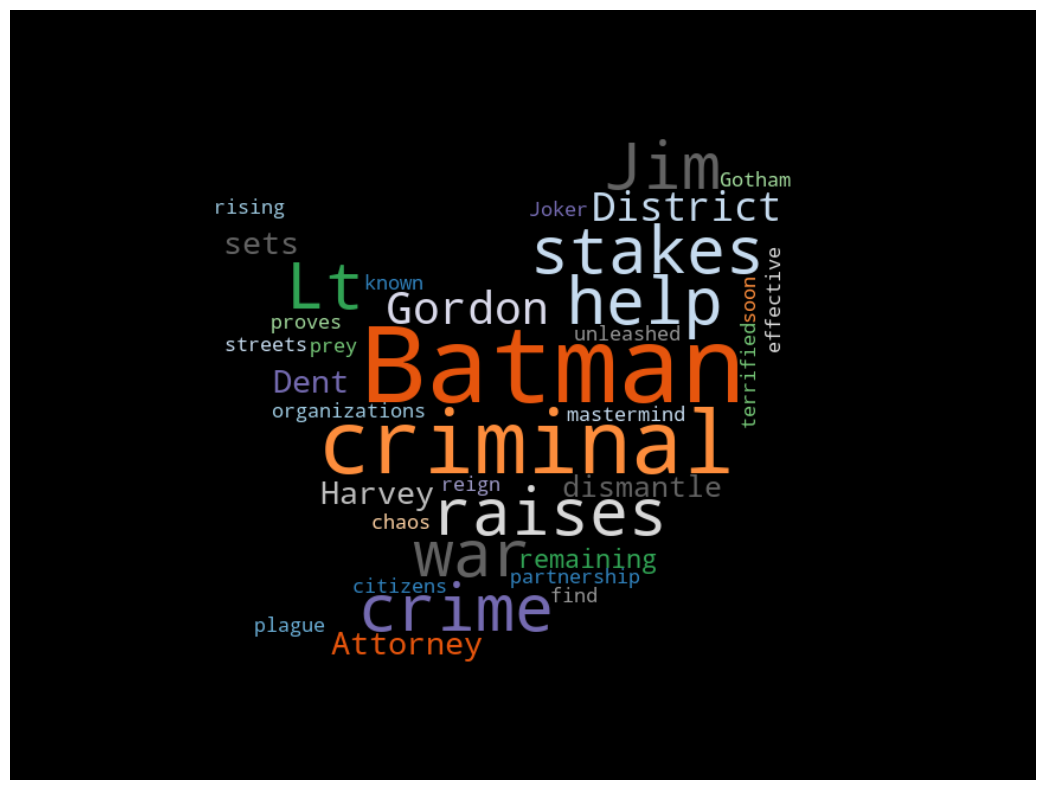

In [35]:
generate_wordcloud('The Dark Knight','tab20c','black',batman)

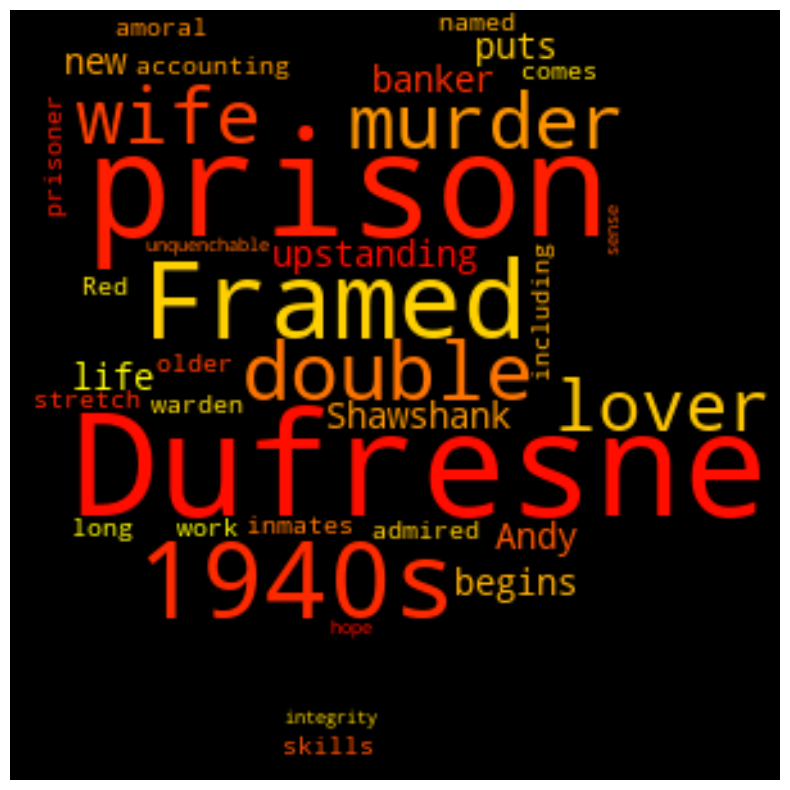

In [36]:
generate_wordcloud('The Shawshank Redemption','autumn','black',star)

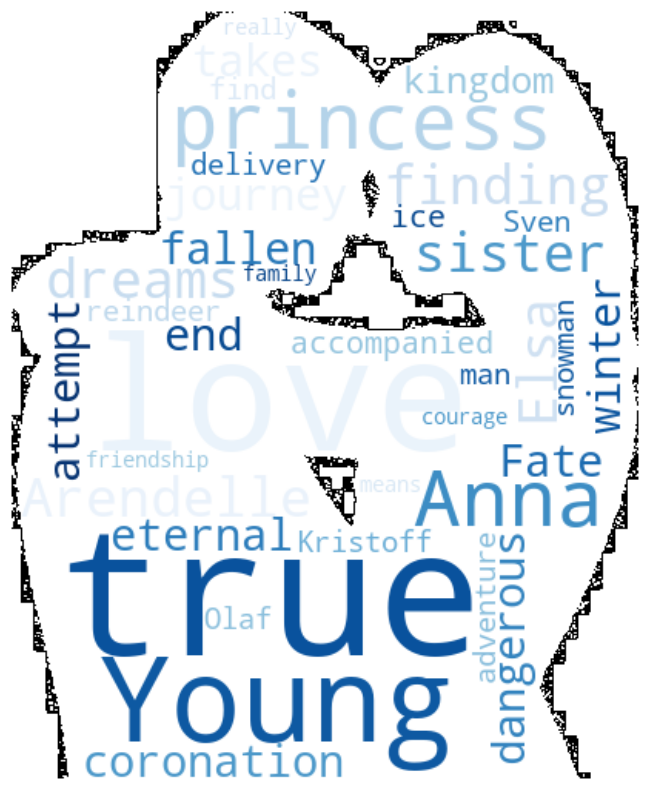

In [37]:
generate_wordcloud('Frozen','Blues_r','white',couple)